# Part 4 - Hyperparameting, Feature Selection and Modelling

### Idea of the model and it's benefit to business
By predicting the probability of default, lenders can classify borrowers according to their risk levels. Default models help in determining the risk premium to be added to the base interest rate charged to the borrower. Higher-risk borrowers, as identified by the model, may be charged a higher interest rate to compensate for the increased risk of default. This risk-based pricing strategy ensures that the lender is adequately compensated for the risk undertaken. 

I will create separate .py files containing functions to extract needed information for each data table. They will be stored in (../data_extraction/scripts/) I will use these files in the pipelines together with  other data preparation steps before modelling. 

#### Importing required a models and functions

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent.absolute()) + "\\app")

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import config
import re
import joblib
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from plotly import graph_objects as go
from hyperopt import hp, space_eval
from hyperopt.pyll.base import scope
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from plotly import express as px
from functions_visualization import (
    plot_precision_recall_and_confusion_matrix,
    show_fig,
    create_contour_plot,
)
from data_extraction.scripts import (
    bureau,
    pos_cash,
    instalment_payments,
    credit_card_balance,
    previous_applications,
    application,
)
from data_extraction.data_extractor_pipe import (
    DataExtractor,
    SequentialDataPipeline,
    ColumnDropper,
    ContractTypeSelector,
    ScaleMinMax,
    RemoveInf,
    ColumnRenamer,
    CategoricalColsConverter,
    get_preprocessing_pipeline,
)

from functions import (
    train_test_sets,
    run_hyperopt,
    add_hover_data,
    prepare_trials_dataframe,
    unpack,
    objective,
    load_or_run_rfecv,
)

from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)

pd.set_option("display.max_columns", None)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

#### Setting access to reach GCP bucket

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_APPLICATION_CREDENTIALS

<IPython.core.display.Javascript object>

#### Defining a pipeline for data collection

I define the order of data collection from different tables and input it into a custom-made SequentialDataPipeline, where it loads each table and merges them one by one based on the selected ID.

Later on, I select only loan type 0 (Cash loans), as we primarily handle these types of loans, and when creating a model, we should focus on one type of loan per model.

Then, I drop unnecessary columns, change infinite values to NaN, and change the data type of categorical columns to 'category'.

In [4]:
preprocessing_pipeline = get_preprocessing_pipeline(
    application_data="application_train.csv"
)

<IPython.core.display.Javascript object>

In [5]:
preprocessing_pipeline

Pipeline(steps=[('data_preparation',
                 SequentialDataPipeline(steps=[('application_data',
                                                DataExtractor(process_function=<function get_data at 0x000001B95BBE6D30>,
                                                              table_name='application_train.csv')),
                                               ('bureau_data',
                                                DataExtractor(process_function=<function get_data at 0x000001B95B2961F0>,
                                                              table_name='bureau.csv')),
                                               ('prev_application_data',
                                                DataExtractor(process...
                                                              table_name='instalments_payments.csv')),
                                               ('credit_card_balance_data',
                                                DataExtractor(process_function=<function get_data at 0x000001B95BBE64C0>,
                                                              table_name='credit_card_balance.csv'))])),
                ('select_loan_type', ContractTypeSelector()),
                ('drop_id_loan_type',
                 ColumnDropper(col_names=['SK_ID_CURR', 'NAME_CONTRACT_TYPE'])),
                ('remove_inf', RemoveInf()),
                ('conver_cat_cols', CategoricalColsConverter())])

<IPython.core.display.Javascript object>

In [6]:
X = preprocessing_pipeline.fit_transform(pd.DataFrame())

<IPython.core.display.Javascript object>

Splitting the data out of pipeline, as I have to re-sample only the train dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_sets(X, "TARGET")

<IPython.core.display.Javascript object>

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.11, random_state=42
)

<IPython.core.display.Javascript object>

Next, I define another pipeline to scale the values and rename the columns to ensure compatibility with the LightGBM model, which does not permit certain special characters. Afterward, I partition the training set to create a validation set, aiming for a target distribution of 80/10/10.

In [9]:
scaler = ScaleMinMax()
modelling_pipeline = Pipeline(
    steps=[
        ("scaler", scaler),
        ("col_renamer", ColumnRenamer()),
    ]
)

<IPython.core.display.Javascript object>

In [10]:
X_train = modelling_pipeline.fit_transform(X=X_train)
X_val = modelling_pipeline.transform(X=X_val)
X_test = modelling_pipeline.transform(X=X_test)

<IPython.core.display.Javascript object>

In [11]:
# scaler.save("default_scaler")

<IPython.core.display.Javascript object>

In [12]:
sampler = RandomUnderSampler(sampling_strategy="not minority")
X_train, y_train = sampler.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

#### Top correlations to target

Now that we have the opportunity to work with fully merged data that includes new variables, let's examine the variables with the highest correlations to the TARGET variable.

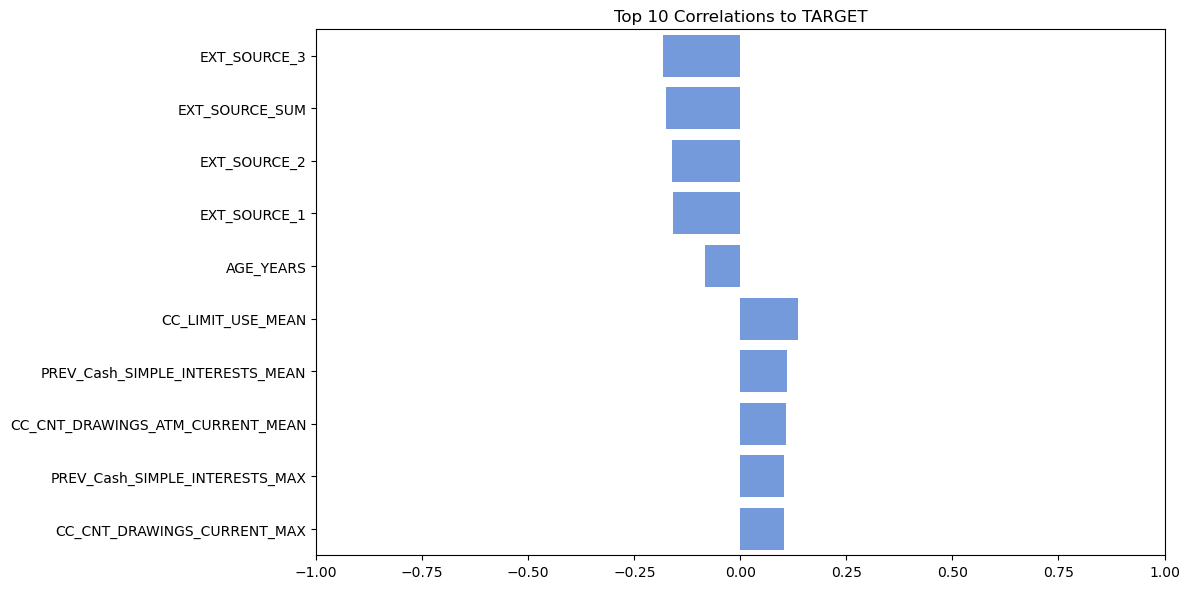

<IPython.core.display.Javascript object>

In [13]:
correlations = pd.Series(index=X.columns, dtype=float)
for col in X.columns:
    if col != "TARGET":
        correlations[col] = X["TARGET"].corr(X[col])

top_corr = correlations.nsmallest(5).append(correlations.nlargest(5))

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    color="cornflowerblue",
)
plt.title("Top 10 Correlations to TARGET")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

- EXT_SOURCE_3, EXT_SOURCE_SUM, EXT_SOURCE_2, and EXT_SOURCE_1 are external data sources and they show the most substantial negative correlations, suggesting their strong predictive power regarding the target.


- AGE_YEARS indicates a negative correlation with the target; older clients are potentially less risky.


- CC_LIMIT_USE_MEAN is correlated with credit card behavior and its positive correlation may suggest that clients who use a moderate proportion of their credit limit are more likely to default.


- PREV_Cash_SIMPLE_INTERESTS_MEAN and PREV_Cash_SIMPLE_INTERESTS_MAX relate to the average and maximum simple interest rates from previous cash transactions, with their positive correlation hinting that higher interest rates are linked with higher default risk.


- CC_CNT_DRAWINGS_ATM_CURRENT_MEAN and CC_CNT_DRAWINGS_CURRENT_MAX represent credit card drawing behaviors, with their positive correlations suggesting that those who draw more frequently from ATMs or have a higher max drawing amount are more likely to default.

#### I will try 2 different paths:

1. Hyperparameting model -> Feature selection with new parameters -> New hyperparameting with newly received features

2. Feature selection with default lightgbm values -> Hyper parameting with newly received features

## 1.Hyperparameting model -> Feature selection with new parameters -> New hyperparameting with newly received features

In [14]:
search_space_ver1 = {
    "model": hp.choice(
        "model",
        [
            {
                "type": "lightgbm",
                "params": {
                    "learning_rate": hp.uniform("lgbm_learning_rate", 0.05, 1),
                    "num_leaves": scope.int(hp.quniform("lgbm_num_leaves", 30, 100, 5)),
                    "n_estimators": scope.int(
                        hp.quniform("lgbm_n_estimators", 100, 5000, 250)
                    ),
                    "max_depth": scope.int(hp.quniform("lgbm_max_depth", 3, 12, 1)),
                    "subsample": hp.uniform("lgbm_subsample", 0.5, 1.0),
                    "colsample_bytree": hp.uniform("lgbm_colsample_bytree", 0.5, 1.0),
                },
            },
            {
                "type": "xgboost",
                "params": {
                    "n_estimators": scope.int(
                        hp.quniform("xgb_n_estimators", 100, 5000, 250)
                    ),
                    "max_depth": scope.int(hp.quniform("xgb_max_depth", 3, 12, 1)),
                    "learning_rate": hp.uniform("xgb_learning_rate", 0.05, 1),
                    "subsample": hp.uniform("xgb_subsample", 0.5, 1.0),
                    "colsample_bytree": hp.uniform("xgb_colsample_bytree", 0.5, 1.0),
                    "gamma": hp.uniform("xgb_gamma", 0, 0.5),
                },
            },
        ],
    ),
}

<IPython.core.display.Javascript object>

In [15]:
best1, trials1 = run_hyperopt(
    "ver1",
    objective,
    search_space_ver1,
    X_train,
    y_train,
    X_val,
    y_val,
    max_evals=150,
    seed=42,
    n_early_stop=25,
    scoring="roc_auc",
)

Loading trials and best parameters from GCS.


<IPython.core.display.Javascript object>

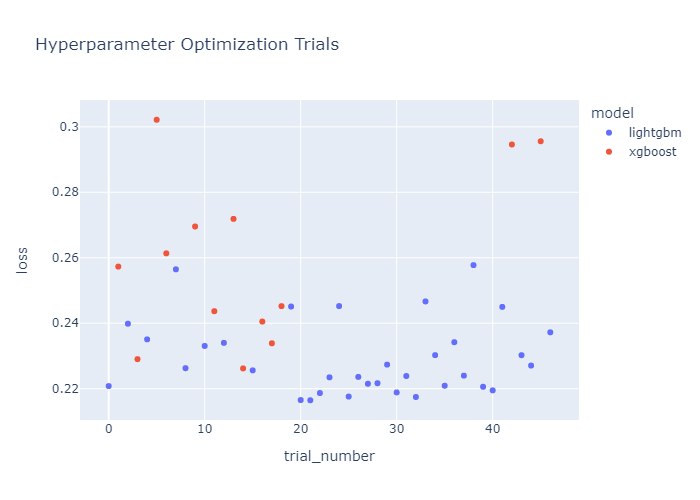

<IPython.core.display.Javascript object>

In [16]:
trials_df1 = prepare_trials_dataframe(trials1)

fig = px.scatter(
    trials_df1,
    x="trial_number",
    y="loss",
    color="model",
    title="Hyperparameter Optimization Trials",
    labels={"x": "Trial Number", "y": "1 - ROC_AUC"},
)


fig = add_hover_data(fig, trials_df1, "lightgbm")
fig = add_hover_data(fig, trials_df1, "xgboost")

# Image rendering to make plotly visible on github. To load chart locally interactive, change this option to "interactive", for git use "image"
show_fig(fig, render="image")

# Recheck 
The best performing model with all features was LGBMClassifier, with these parameters:

- learning rate = 0.2
- max_depth = 10
- n_estimators = 3250
- num_leaves = 90
- subsample = 0.81


In [17]:
best_param_lgbm = space_eval(search_space_ver1, best1)["model"]["params"]
model_lgbm1 = LGBMClassifier(**best_param_lgbm, random_state=42, verbose=-1)
model_lgbm1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5130716747148132,
               learning_rate=0.05407427478808231, max_depth=9,
               n_estimators=3500, num_leaves=100, random_state=42,
               subsample=0.6880108917138817, verbose=-1)

<IPython.core.display.Javascript object>

In [18]:
y_pred1 = model_lgbm1.predict_proba(X_test)[:, 1]

roc_auc_1 = roc_auc_score(y_test, y_pred1)
print("LGBMClassifier Performance after hyperparameting and before feature selection:")
print("ROC AUC:", roc_auc_1)

LGBMClassifier Performance after hyperparameting and before feature selection:
ROC AUC: 0.783609424828171


<IPython.core.display.Javascript object>

I won’t comment extensively on this model for now, as we will evaluate its performance in more detail after feature selection has been conducted.

### FEATURE SELECTION 

In [19]:
rfecv1 = load_or_run_rfecv(
    name="rfecv_hyperparamed_ver1",
    classifier=LGBMClassifier(**best_param_lgbm, random_state=42, verbose=-1),
    X=X_train,
    y=y_train,
    min_features_to_select=100,
    step=3,
    cv=2,
    scoring="roc_auc",
)

<IPython.core.display.Javascript object>

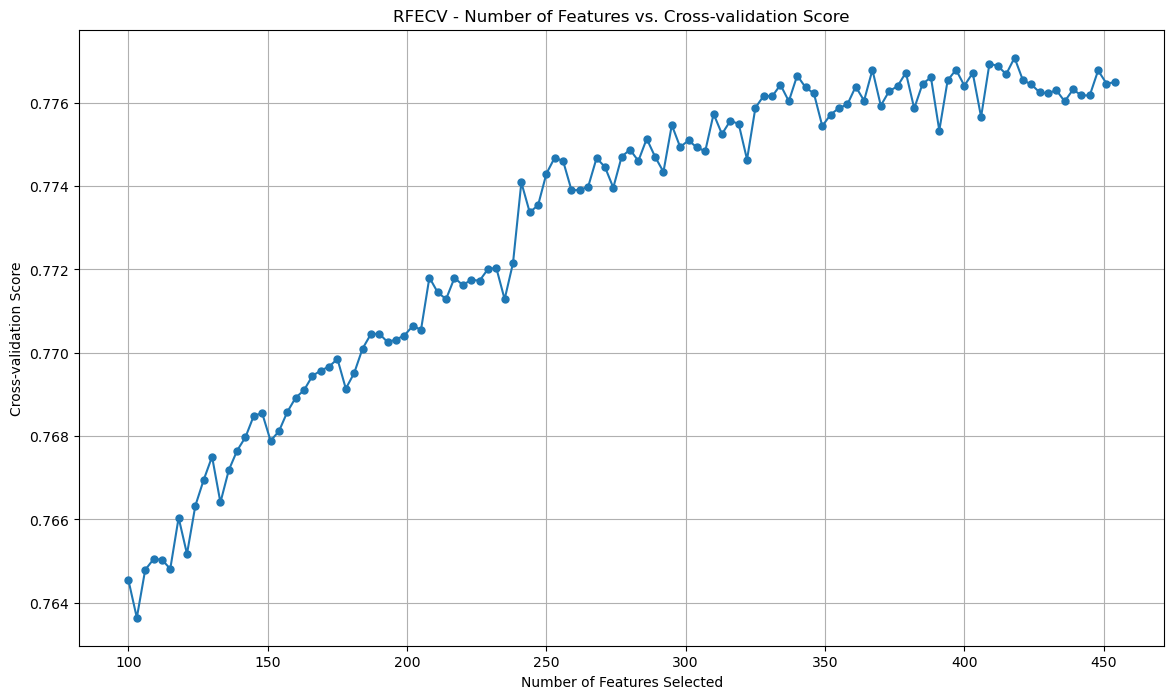

<IPython.core.display.Javascript object>

In [20]:
initial_feature_count = X_train.shape[1]
step = 3 

n_features_evaluated = np.arange(initial_feature_count, 0, -step)[:len(rfecv1.cv_results_['mean_test_score'])][::-1]

plt.figure(figsize=(14, 8))
plt.plot(n_features_evaluated, rfecv1.cv_results_['mean_test_score'], marker='o', linestyle='-', markersize=5)
plt.title("RFECV - Number of Features vs. Cross-validation Score")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-validation Score")
plt.grid(True)
plt.show()


Overall, we observe an upward trend in performance as more features are incorporated, though with notable fluctuations. Sharp rises or falls in scores resulting from the addition or subtraction of a small number of features suggest a substantial influence of specific features on the model's performance. Notably, the peak scores do not always align with the greatest number of features, underscoring the significance of feature selection to enhance model accuracy.

In [21]:
selected_feature_indices = rfecv1.support_
selected_columns = X_test.loc[:, selected_feature_indices].columns.values
X_train_sel = X_train[selected_columns]
X_val_sel = X_val[selected_columns]
X_test_sel = X_test[selected_columns]

<IPython.core.display.Javascript object>

In [22]:
best2, trials2 = run_hyperopt(
    "after_feat_sel_hyperp2",
    objective,
    search_space_ver1,
    X_train_sel,
    y_train,
    X_val_sel,
    y_val,
    max_evals=150,
    seed=42,
    n_early_stop=25,
    scoring="roc_auc",
)

Loading trials and best parameters from GCS.


<IPython.core.display.Javascript object>

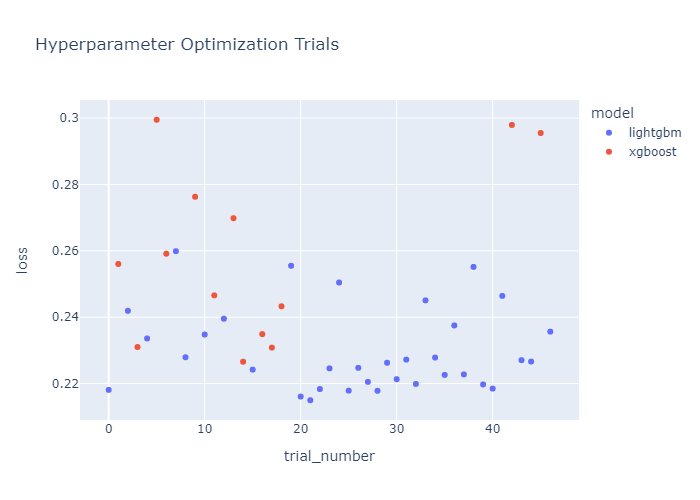

<IPython.core.display.Javascript object>

In [23]:
trials_df2 = prepare_trials_dataframe(trials2)

fig = px.scatter(
    trials_df2,
    x="trial_number",
    y="loss",
    color="model",
    title="Hyperparameter Optimization Trials",
    labels={"x": "Trial Number", "y": "Recall"},
)


fig = add_hover_data(fig, trials_df2, "lightgbm")
fig = add_hover_data(fig, trials_df2, "xgboost")

# Image rendering to make plotly visible on github. To load chart locally interactive, change this option to "interactive"
show_fig(fig, render="image")

In [24]:
space_eval(search_space_ver1, best2)

{'model': {'params': {'colsample_bytree': 0.5130716747148132,
   'learning_rate': 0.05407427478808231,
   'max_depth': 9,
   'n_estimators': 3500,
   'num_leaves': 100,
   'subsample': 0.6880108917138817},
  'type': 'lightgbm'}}

<IPython.core.display.Javascript object>

In [25]:
best_param_lgbm_2 = space_eval(search_space_ver1, best2)["model"]["params"]
model_lgbm2 = LGBMClassifier(**best_param_lgbm, random_state=42, verbose=-1)
model_lgbm2.fit(X_train_sel, y_train)

LGBMClassifier(colsample_bytree=0.5130716747148132,
               learning_rate=0.05407427478808231, max_depth=9,
               n_estimators=3500, num_leaves=100, random_state=42,
               subsample=0.6880108917138817, verbose=-1)

<IPython.core.display.Javascript object>

In [26]:
y_pred2 = model_lgbm2.predict_proba(X_test_sel)[:, 1]
print("LGBMClassifier Performance after hyperparameting and feature selection:")
roc_auc_2 = roc_auc_score(y_test, y_pred2)
print("ROC AUC:", roc_auc_2)

LGBMClassifier Performance after hyperparameting and feature selection:
ROC AUC: 0.784213921527018


<IPython.core.display.Javascript object>

After the feature selection, the LGBM Classifier showed the best performance, exhibiting similar patterns in performance metrics compared to its earlier version. This suggests that the feature selection successfully removed superfluous or minimally informative features without adversely affecting the model's default prediction capability. Nevertheless, the results fell short of my expectations for enhancement. I suspect that our approach may not be entirely effective since the model was initially trained on a dataset with more features, potentially hindering our ability to discern the truly optimal feature set.

# 2. Default LGBM parameters -> Feature selection with default lightgbm parameters -> Hyper parameting with newly received features

In [27]:
default_lgbm = LGBMClassifier(random_state=42, verbose=-1)
default_lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=42, verbose=-1)

<IPython.core.display.Javascript object>

In [28]:
y_pred_default = default_lgbm.predict_proba(X_test)[:, 1]
roc_auc_def = roc_auc_score(y_test, y_pred_default)
print("ROC AUC:", roc_auc_def)

ROC AUC: 0.7824321461308369


<IPython.core.display.Javascript object>

In [29]:
rfecv_default_lgbm_ver2 = load_or_run_rfecv(
    name="rfecv_default_lgbm_ver2",
    classifier=LGBMClassifier(verbose=-1, random_state=42),
    X=X_train,
    y=y_train,
    min_features_to_select=75,
    step=3,
    cv=2,
    scoring="roc_auc",
)

<IPython.core.display.Javascript object>

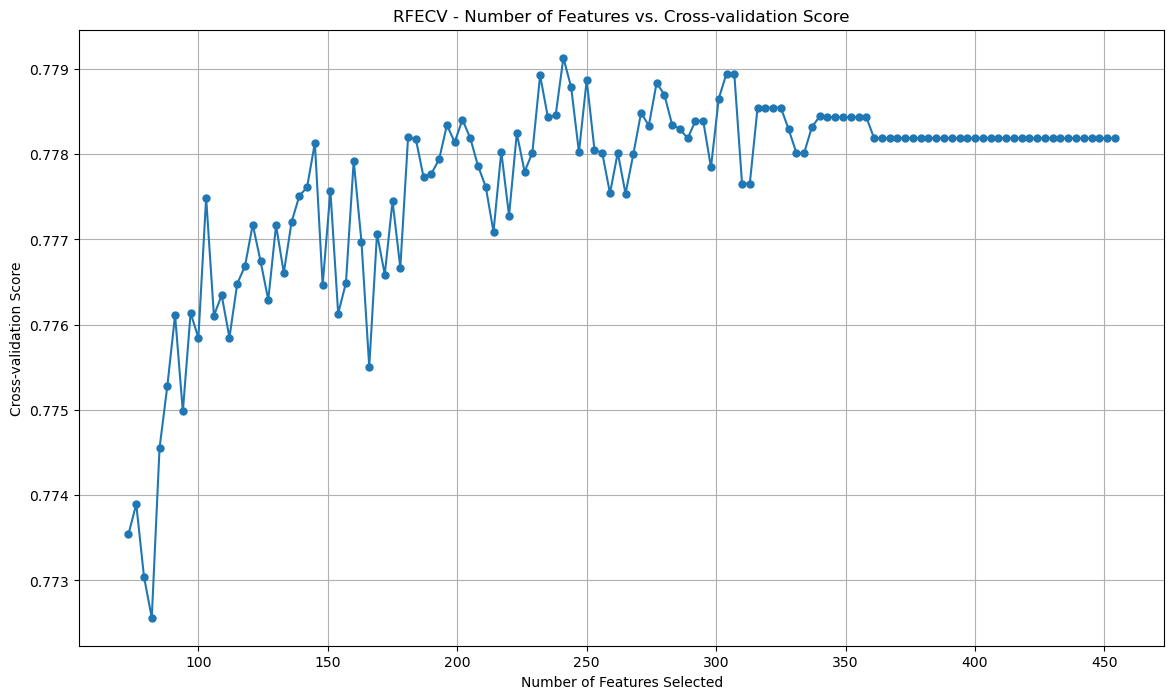

<IPython.core.display.Javascript object>

In [30]:
initial_feature_count = X_train.shape[1]
step = 3
n_features_evaluated = np.arange(initial_feature_count, 0, -step)[
    : len(rfecv_default_lgbm_ver2.cv_results_["mean_test_score"])
][::-1]

plt.figure(figsize=(14, 8))
plt.plot(
    n_features_evaluated,
    rfecv_default_lgbm_ver2.cv_results_["mean_test_score"],
    marker="o",
    linestyle="-",
    markersize=5,
)
plt.title("RFECV - Number of Features vs. Cross-validation Score")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-validation Score")
plt.grid(True)
plt.show()

Currently, an optimal set of 238 features has been selected, which is a reduction of more than 100 from the previous count of 342. This demonstrates that altering the sequence of steps in the modeling process can indeed affect performance. By performing feature selection with a default LightGBM model prior to hyperparameter tuning, we're able to more efficiently pinpoint the most pertinent features. The next step will be to conduct hyperparameter tuning on this refined feature set to evaluate the resulting performance.

In [31]:
selected_feature_indices = rfecv_default_lgbm_ver2.support_
selected_columns = X_test.loc[:, selected_feature_indices].columns.values
X_train_sel2 = X_train[selected_columns]
X_val_sel2 = X_val[selected_columns]
X_test_sel2 = X_test[selected_columns]

<IPython.core.display.Javascript object>

In [32]:
search_space_def_feat_s2 = {
    "model": hp.choice(
        "model",
        [
            {
                "type": "lightgbm",
                "params": {
                    "learning_rate": hp.uniform("lgbm_learning_rate", 0.01, 0.3),
                    "num_leaves": scope.int(hp.quniform("lgbm_num_leaves", 30, 100, 5)),
                    "n_estimators": scope.int(
                        hp.quniform("lgbm_n_estimators", 25, 2500, 50)
                    ),
                    "max_depth": scope.int(hp.quniform("lgbm_max_depth", 3, 14, 1)),
                    "subsample": hp.uniform("lgbm_subsample", 0.3, 1.0),
                    "colsample_bytree": hp.uniform("lgbm_colsample_bytree", 0.3, 1.0),
                },
            },
            {
                "type": "xgboost",
                "params": {
                    "n_estimators": scope.int(
                        hp.quniform("xgb_n_estimators", 25, 2500, 50)
                    ),
                    "max_depth": scope.int(hp.quniform("xgb_max_depth", 3, 14, 1)),
                    "learning_rate": hp.uniform("xgb_learning_rate", 0.01, 0.3),
                    "subsample": hp.uniform("xgb_subsample", 0.3, 1.0),
                    "colsample_bytree": hp.uniform("xgb_colsample_bytree", 0.3, 1.0),
                    "gamma": hp.uniform("xgb_gamma", 0, 0.5),
                },
            },
        ],
    ),
}


<IPython.core.display.Javascript object>

In [33]:
best, trials = run_hyperopt(
    "after_feat_sel_default3",
    objective,
    search_space_def_feat_s2,
    X_train_sel2,
    y_train,
    X_val_sel2,
    y_val,
    max_evals=500,
    seed=40,
    n_early_stop=500,
    scoring="roc_auc",
)

Loading trials and best parameters from GCS.


<IPython.core.display.Javascript object>

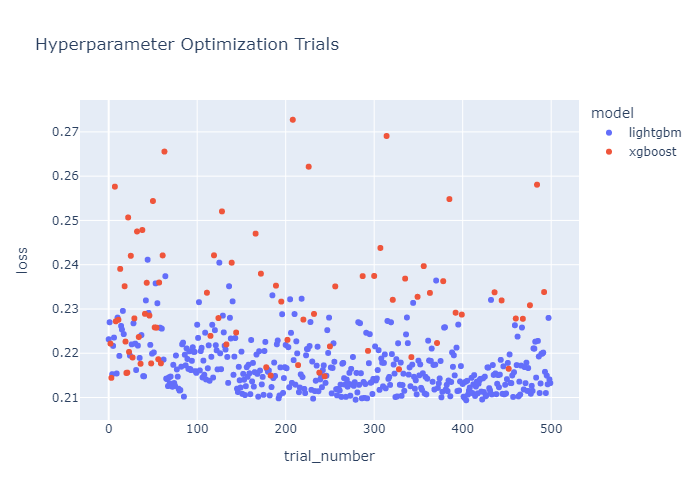

<IPython.core.display.Javascript object>

In [34]:
trials_df = prepare_trials_dataframe(trials)

fig = px.scatter(
    trials_df,
    x="trial_number",
    y="loss",
    color="model",
    title="Hyperparameter Optimization Trials",
    labels={"x": "Trial Number", "y": "Recall"},
)


fig = add_hover_data(fig, trials_df, "lightgbm")
fig = add_hover_data(fig, trials_df, "xgboost")

# Image rendering to make plotly visible on github. To load chart locally interactive, delete this option
show_fig(fig, render="image")

In [35]:
space_eval(search_space_def_feat_s2, best)

{'model': {'params': {'colsample_bytree': 0.3329698431888426,
   'learning_rate': 0.01637452115070448,
   'max_depth': 13,
   'n_estimators': 1150,
   'num_leaves': 50,
   'subsample': 0.6575568154132652},
  'type': 'lightgbm'}}

<IPython.core.display.Javascript object>

In [36]:
best_param_lgbm = space_eval(search_space_def_feat_s2, best)["model"]["params"]
model_lgbm3 = LGBMClassifier(**best_param_lgbm, random_state=42, verbose=-1)
model_lgbm3.fit(X_train_sel2, y_train)

LGBMClassifier(colsample_bytree=0.3329698431888426,
               learning_rate=0.01637452115070448, max_depth=13,
               n_estimators=1150, num_leaves=50, random_state=42,
               subsample=0.6575568154132652, verbose=-1)

<IPython.core.display.Javascript object>

In [37]:
y_pred3 = model_lgbm3.predict_proba(X_test_sel2)[:, 1]
roc_auc_3 = roc_auc_score(y_test, y_pred3)
roc_auc_3

0.7900891043162308

<IPython.core.display.Javascript object>

Above, the best-performing parameters are presented. Prior to executing our model, let's examine the entire search space and its performance.

Overall, LightGBM trials (represented by blue dots) are densely clustered around lower loss values compared to XGBoost trials (represented by red dots), suggesting that LightGBM models consistently outperformed XGBoost on the optimization task at hand.

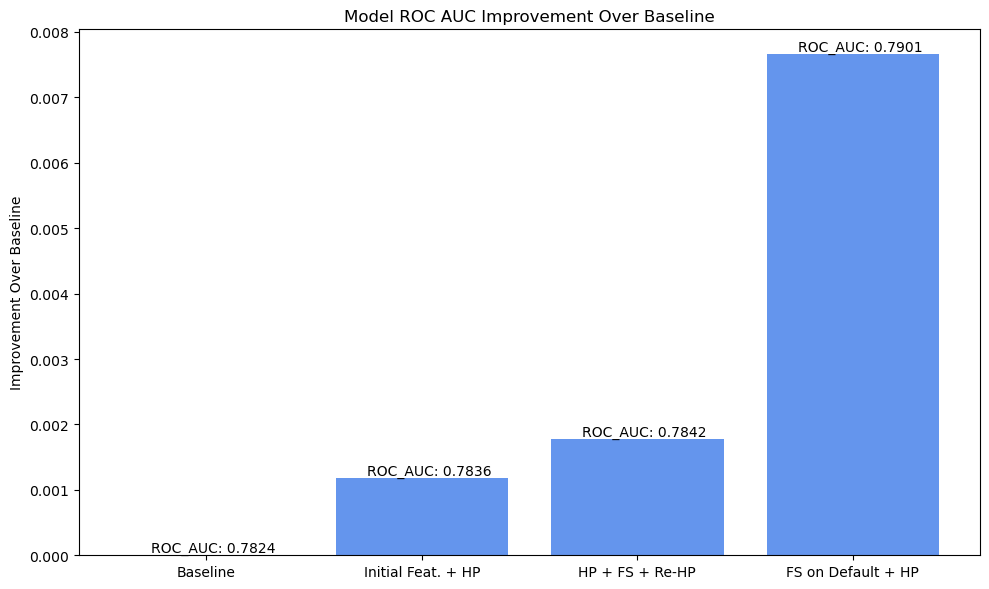

<IPython.core.display.Javascript object>

In [62]:
roc_auc_scores = np.array([roc_auc_def, roc_auc_1, roc_auc_2, roc_auc_3])
baseline = roc_auc_def
differences = roc_auc_scores - baseline

model_names = [
    "Baseline",
    "Initial Feat. + HP",
    "HP + FS + Re-HP",
    "FS on Default + HP",
]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, differences, color="cornflowerblue")

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 5.5,
        yval,
        f"ROC_AUC: {yval+baseline:.4f}",
        va="bottom",
    )

plt.title("Model ROC AUC Improvement Over Baseline")
plt.ylabel("Improvement Over Baseline")


plt.tight_layout()
plt.show()

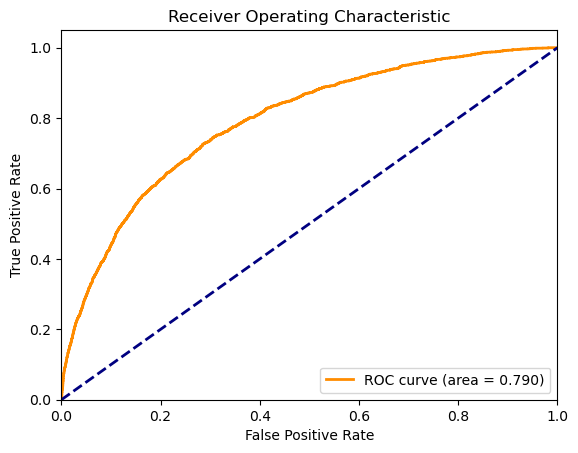

<IPython.core.display.Javascript object>

In [65]:
y_scores = model_lgbm3.predict_proba(X_test_sel2)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

Compared to the previously mentioned models, we have managed to enhance its performance, albeit modestly, by 0.008 from the baseline. The ROC curve showcases the model's adeptness at differentiating between classes, with an AUC of 0.79 signaling robust predictive capability. The curve's progression suggests the model can attain a high true positive rate without a corresponding increase in the false positive rate, benefiting reliable prediction outcomes.

#### Optimal parameters of best performing model

#### max_depth vs n_estimators

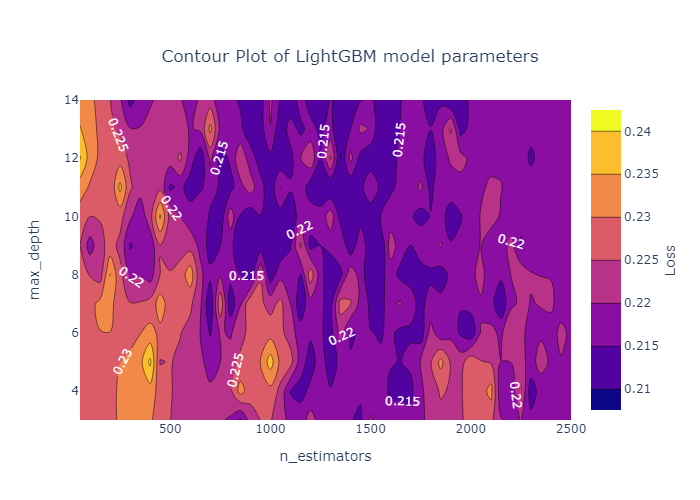

<IPython.core.display.Javascript object>

In [39]:
fig = create_contour_plot(
    trials_df,
    "lgbm_n_estimators",
    "lgbm_max_depth",
    "lightgbm",
    "n_estimators",
    "max_depth",
    "Contour Plot of LightGBM model parameters",
)
# Image rendering to make plotly visible on github. To load chart locally interactive, delete this option
show_fig(fig, render="image")

An area exhibiting the lowest loss (indicative of the highest performance) can be identified with a relatively low number of estimators (approximately 200 to 500) and a high max depth range (about 8 to 10). This pattern implies that a model with a larger number of trees (higher n_estimators) combined with moderately deep trees strikes an optimal balance for this specific dataset. It suggests that the model benefits from the complexity of deeper decision trees without necessitating an excessively large ensemble

#### learning_rate vs n_estimators and max_depth

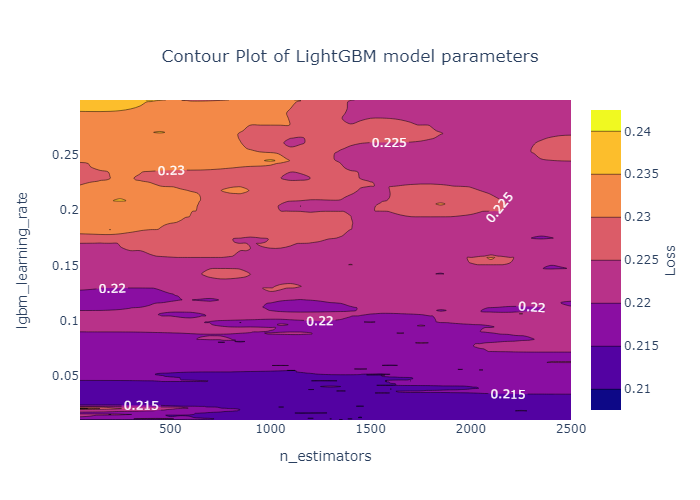

<IPython.core.display.Javascript object>

In [40]:
fig = create_contour_plot(
    trials_df,
    "lgbm_n_estimators",
    "lgbm_learning_rate",
    "lightgbm",
    "n_estimators",
    "lgbm_learning_rate",
    "Contour Plot of LightGBM model parameters",
)

# Image rendering to make plotly visible on github. To load chart locally interactive, delete this option
show_fig(fig, render="image")

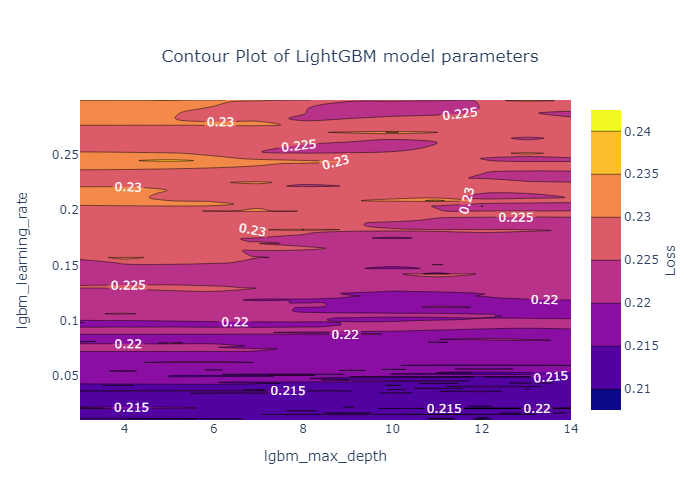

<IPython.core.display.Javascript object>

In [41]:
fig = create_contour_plot(
    trials_df,
    "lgbm_max_depth",
    "lgbm_learning_rate",
    "lightgbm",
    "lgbm_max_depth",
    "lgbm_learning_rate",
    "Contour Plot of LightGBM model parameters",
)

# Image rendering to make plotly visible on github. To load chart locally interactive, delete this option
show_fig(fig, render="image")

In both charts, we observe that the lowest loss values are concentrated where the learning rate is below 0.1. Notably, these lower loss values occur across a broad spectrum of max_depth and n_estimators, indicating that a smaller learning rate enhances model performance over a wide range of configurations for these parameters.

#### Finding optimal threshold

In [48]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.linspace(0.25, 0.75, num=100)

f2_scores = []
f3_scores = []

for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)

    _, _, f2, _ = precision_recall_fscore_support(
        y_test, y_pred, beta=2, average="binary", zero_division=0
    )
    _, _, f3, _ = precision_recall_fscore_support(
        y_test, y_pred, beta=3, average="binary", zero_division=0
    )

    f2_scores.append(f2)
    f3_scores.append(f3)

optimal_f2_threshold = thresholds[np.argmax(f2_scores)]
optimal_f3_threshold = thresholds[np.argmax(f3_scores)]

print("Optimal F2 Threshold:", optimal_f2_threshold)
print("Optimal F3 Threshold:", optimal_f3_threshold)

Optimal F2 Threshold: 0.5681818181818182
Optimal F3 Threshold: 0.38636363636363635


<IPython.core.display.Javascript object>

In [60]:
y_pred_optimal_f2 = (y_scores >= optimal_f2_threshold).astype(int)
print("Optimal F2 Threshold Performance:")
print(classification_report(y_test, y_pred_optimal_f2))
print("----------------------------------------------------------")
y_pred_optimal_f3 = (y_scores >= optimal_f3_threshold).astype(int)
print("Optimal F3 Threshold Performance:")
print(classification_report(y_test, y_pred_optimal_f3))

Optimal F2 Threshold Performance:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     25559
           1       0.21      0.64      0.32      2265

    accuracy                           0.78     27824
   macro avg       0.59      0.71      0.59     27824
weighted avg       0.90      0.78      0.82     27824

----------------------------------------------------------
Optimal F3 Threshold Performance:
              precision    recall  f1-score   support

           0       0.97      0.59      0.73     25559
           1       0.15      0.83      0.25      2265

    accuracy                           0.61     27824
   macro avg       0.56      0.71      0.49     27824
weighted avg       0.91      0.61      0.69     27824



<IPython.core.display.Javascript object>

###### In this business case, achieving a high recall for the positive class is crucial, however, we cannot afford to compromise precision as drastically as the optimal F3 threshold does. To identify an optimal value, a company should conduct a cost-benefit analysis. I believe the optimal F2 threshold should be used for deployment — incorrectly classifying too many loans as having a high risk of default could incur greater costs than benefits. Customers might receive significantly better offers from competitors.


#### Feature importance

In [52]:
shap_values = shap.TreeExplainer(model_lgbm3).shap_values(X_test_sel2)

C:\Users\matas\anaconda3\lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



<IPython.core.display.Javascript object>

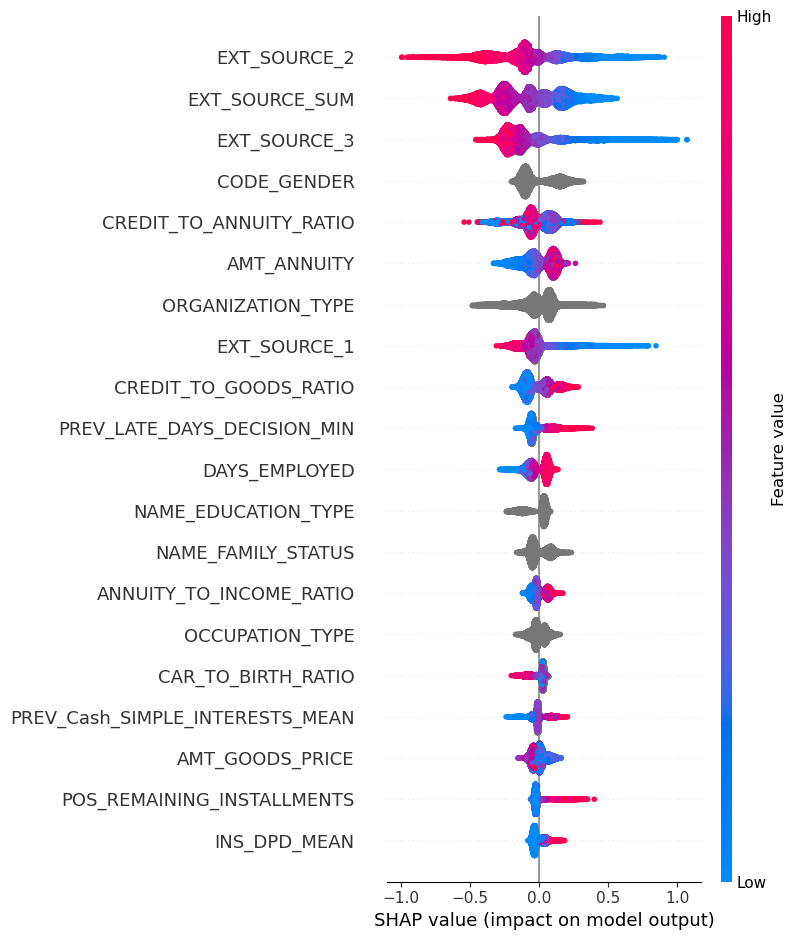

<IPython.core.display.Javascript object>

In [53]:
shap.summary_plot(shap_values, X_test_sel2)

The most influential features in the model are EXT_SOURCE_SUM, EXT_SOURCE_2, and EXT_SOURCE_3, with EXT_SOURCE_SUM emerging as the most critical, boasting a notably higher importance score than the others. ORGANIZATION_TYPE and certain ratios, such as CREDIT_TO_ANNUITY_RATIO and CREDIT_TO_GOODS_RATIO, also play a pivotal role in the prediction process.

Additionally, features reflecting the client's age (DAYS_BIRTH), employment duration (DAYS_EMPLOYED), and the ratio of employment time to age (EMPLOYED_TO_BIRTH_RATIO) significantly impact the model's outcomes. This underscores the importance of personal and demographic factors in determining the predictions.

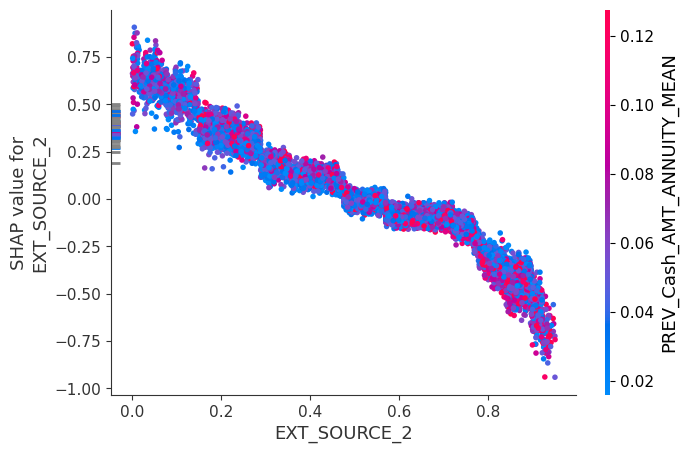

<IPython.core.display.Javascript object>

In [54]:
shap.dependence_plot("EXT_SOURCE_2", shap_values, X_test_sel2)

The plot suggests a trend where higher values of EXT_SOURCE_2 correlate with lower SHAP values, indicating a decrease in the likelihood of defaulting a loan. The intensity of color, representing the PREV_CASH_AMT_ANNUITY_MEAN feature, doesn't show a clear pattern with respect to EXT_SOURCE_2 values, implying that this feature may not interact strongly with EXT_SOURCE_2 in the model's predictions.

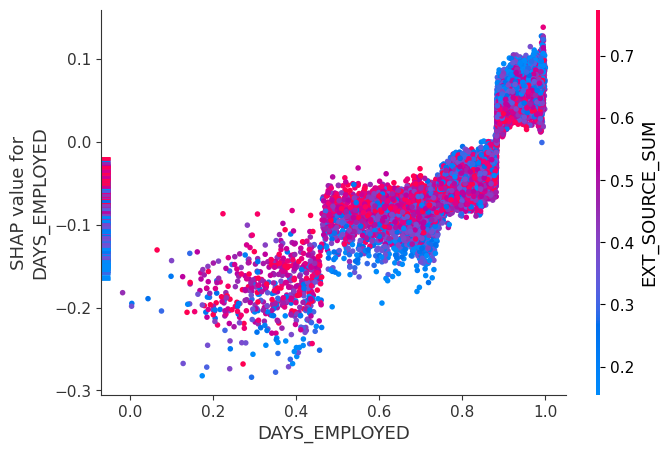

<IPython.core.display.Javascript object>

In [57]:
shap.dependence_plot("DAYS_EMPLOYED", shap_values, X_test_sel2)

The plot indicates that as DAYS_EMPLOYED increases, the SHAP values trend downward, which suggests that being employed for more days is associated with a decreased likelihood of loan default. However, there's an uptick in SHAP values at the highest end of DAYS_EMPLOYED, implying a more complex, non-linear relationship. The EXT_SOURCE_SUM feature, indicated by the color gradient, shows that for this subset of data, lower values of EXT_SOURCE_SUM tend to coincide with higher DAYS_EMPLOYED, but there's no clear linear trend between these two features.

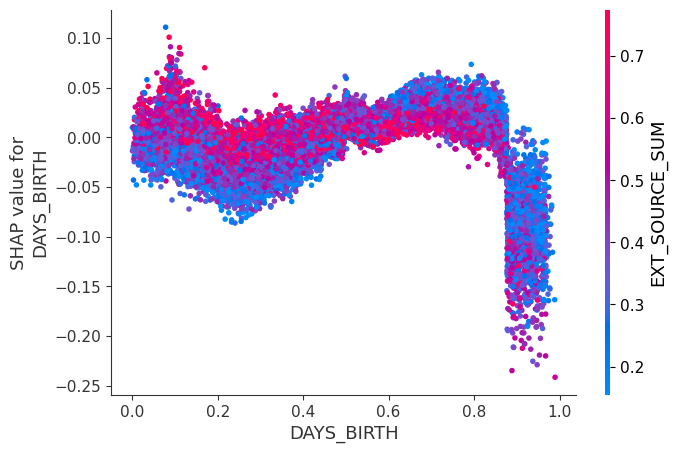

<IPython.core.display.Javascript object>

In [58]:
shap.dependence_plot("DAYS_BIRTH", shap_values, X_test_sel2)

The SHAP values in this plot primarily hover close to zero but decrease slightly with increasing DAYS_BIRTH, which could suggest that older age has a small, negative effect on the probability of default according to the model. The EXT_SOURCE_SUM, indicated by the color, shows a concentration of lower values among older ages, as evidenced by the shift from red to blue as DAYS_BIRTH increases, suggesting a potential interaction where older individuals may also have lower external source sums in this data set.

#### Exporting model

In [68]:
from google.cloud import storage
from io import BytesIO

storage_client = storage.Client()
bucket = storage_client.bucket(config.BUCKET_NAME)
blob = bucket.blob(f"{config.MODELS_FOLDER}default_model_lgb.pkl")

if not blob.exists():
    byte_stream = BytesIO()
    joblib.dump(model_lgbm3, byte_stream)
    byte_stream.seek(0)
    blob.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(f"Model saved to GCP bucket: {blob}")

Model saved to GCP bucket: <Blob: loandefault-bckt, models/default_model_lgb.pkl, 1712142179085609>


<IPython.core.display.Javascript object>